In [1]:
import numpy as np
import pandas as pd
import os

# === Set Paths ===
base_path = "/Users/temp/Documents/ENGO 623/motion-detection/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/"
save_path = "/Users/temp/Documents/ENGO 623/motion-detection/traditional-method/"

# === Load Raw Accelerometer Data ===
acc_x = np.loadtxt(os.path.join(base_path, "Inertial Signals/total_acc_x_train.txt"))
acc_y = np.loadtxt(os.path.join(base_path, "Inertial Signals/total_acc_y_train.txt"))
acc_z = np.loadtxt(os.path.join(base_path, "Inertial Signals/total_acc_z_train.txt"))
gyro_x = np.loadtxt(os.path.join(base_path, "Inertial Signals/body_gyro_x_train.txt"))
gyro_y = np.loadtxt(os.path.join(base_path, "Inertial Signals/body_gyro_y_train.txt"))
gyro_z = np.loadtxt(os.path.join(base_path, "Inertial Signals/body_gyro_z_train.txt"))

# === Load Activity Labels and Subject IDs ===
y_labels = np.loadtxt(os.path.join(base_path, "y_train.txt"), dtype=int)
subject_ids = np.loadtxt(os.path.join(base_path, "subject_train.txt"), dtype=int)

print("✅ Raw data loaded.")
print("acc_x shape:", acc_x.shape)
print("gyro_x shape:", gyro_x.shape)
print("y_labels shape:", y_labels.shape)

# === Reconstruct Signal from Overlapping Windows ===
def reconstruct_signal(axis_data):
    signal = []
    for i in range(len(axis_data)):
        if i == 0:
            signal.extend(axis_data[i])           # Full 128 samples for first window
        else:
            signal.extend(axis_data[i][64:])      # Only last 64 samples for others
    return np.array(signal)

# Reconstruct each axis
acc_x_signal = reconstruct_signal(acc_x)
acc_y_signal = reconstruct_signal(acc_y)
acc_z_signal = reconstruct_signal(acc_z)
gyro_x_signal = reconstruct_signal(gyro_x)
gyro_y_signal = reconstruct_signal(gyro_y)
gyro_z_signal = reconstruct_signal(gyro_z)
# === Expand Labels and Subject IDs to Match Sample Count ===
expanded_labels = []
expanded_subjects = []

for i in range(len(y_labels)):
    if i == 0:
        expanded_labels.extend([y_labels[i]] * 128)
        expanded_subjects.extend([subject_ids[i]] * 128)
    else:
        expanded_labels.extend([y_labels[i]] * 64)
        expanded_subjects.extend([subject_ids[i]] * 64)

expanded_labels = np.array(expanded_labels)
expanded_subjects = np.array(expanded_subjects)

# === Combine All into Final Dataset ===
acc_xyz = np.stack((acc_x_signal, acc_y_signal, acc_z_signal), axis=1)
acc_labeled = np.hstack((
    acc_xyz,
    expanded_labels.reshape(-1, 1),
    expanded_subjects.reshape(-1, 1)
))

gyro_xyz = np.stack((gyro_x_signal, gyro_y_signal, gyro_z_signal), axis=1)
gyro_labeled = np.hstack((
    gyro_xyz,
    expanded_labels.reshape(-1, 1),
    expanded_subjects.reshape(-1, 1)
))

print("✅ Final acc dataset shape:", acc_labeled.shape)
print("✅ Final gyro dataset shape:", gyro_labeled.shape)

# === Save as CSV ===
df = pd.DataFrame(acc_labeled, columns=["acc_x", "acc_y", "acc_z", "activity_label", "subject_id"])
csv_path = os.path.join(save_path, "acc_labeled_dataset.csv")
df.to_csv(csv_path, index=False)
print("✅ Saved to:", csv_path)

df = pd.DataFrame(gyro_labeled, columns=["gyro_x", "gyro_y", "gyro_z", "activity_label", "subject_id"])
csv_path = os.path.join(save_path, "gyro_labeled_dataset.csv")
df.to_csv(csv_path, index=False)
print("✅ Saved to:", csv_path)

✅ Raw data loaded.
acc_x shape: (7352, 128)
gyro_x shape: (7352, 128)
y_labels shape: (7352,)
✅ Final acc dataset shape: (470592, 5)
✅ Final gyro dataset shape: (470592, 5)
✅ Saved to: /Users/temp/Documents/ENGO 623/motion-detection/traditional-method/acc_labeled_dataset.csv
✅ Saved to: /Users/temp/Documents/ENGO 623/motion-detection/traditional-method/gyro_labeled_dataset.csv



✅ Total Detected Steps: 772

✅ Step Count by Activity:
WALKING: 215 steps
WALKING_UPSTAIRS: 104 steps
WALKING_DOWNSTAIRS: 109 steps


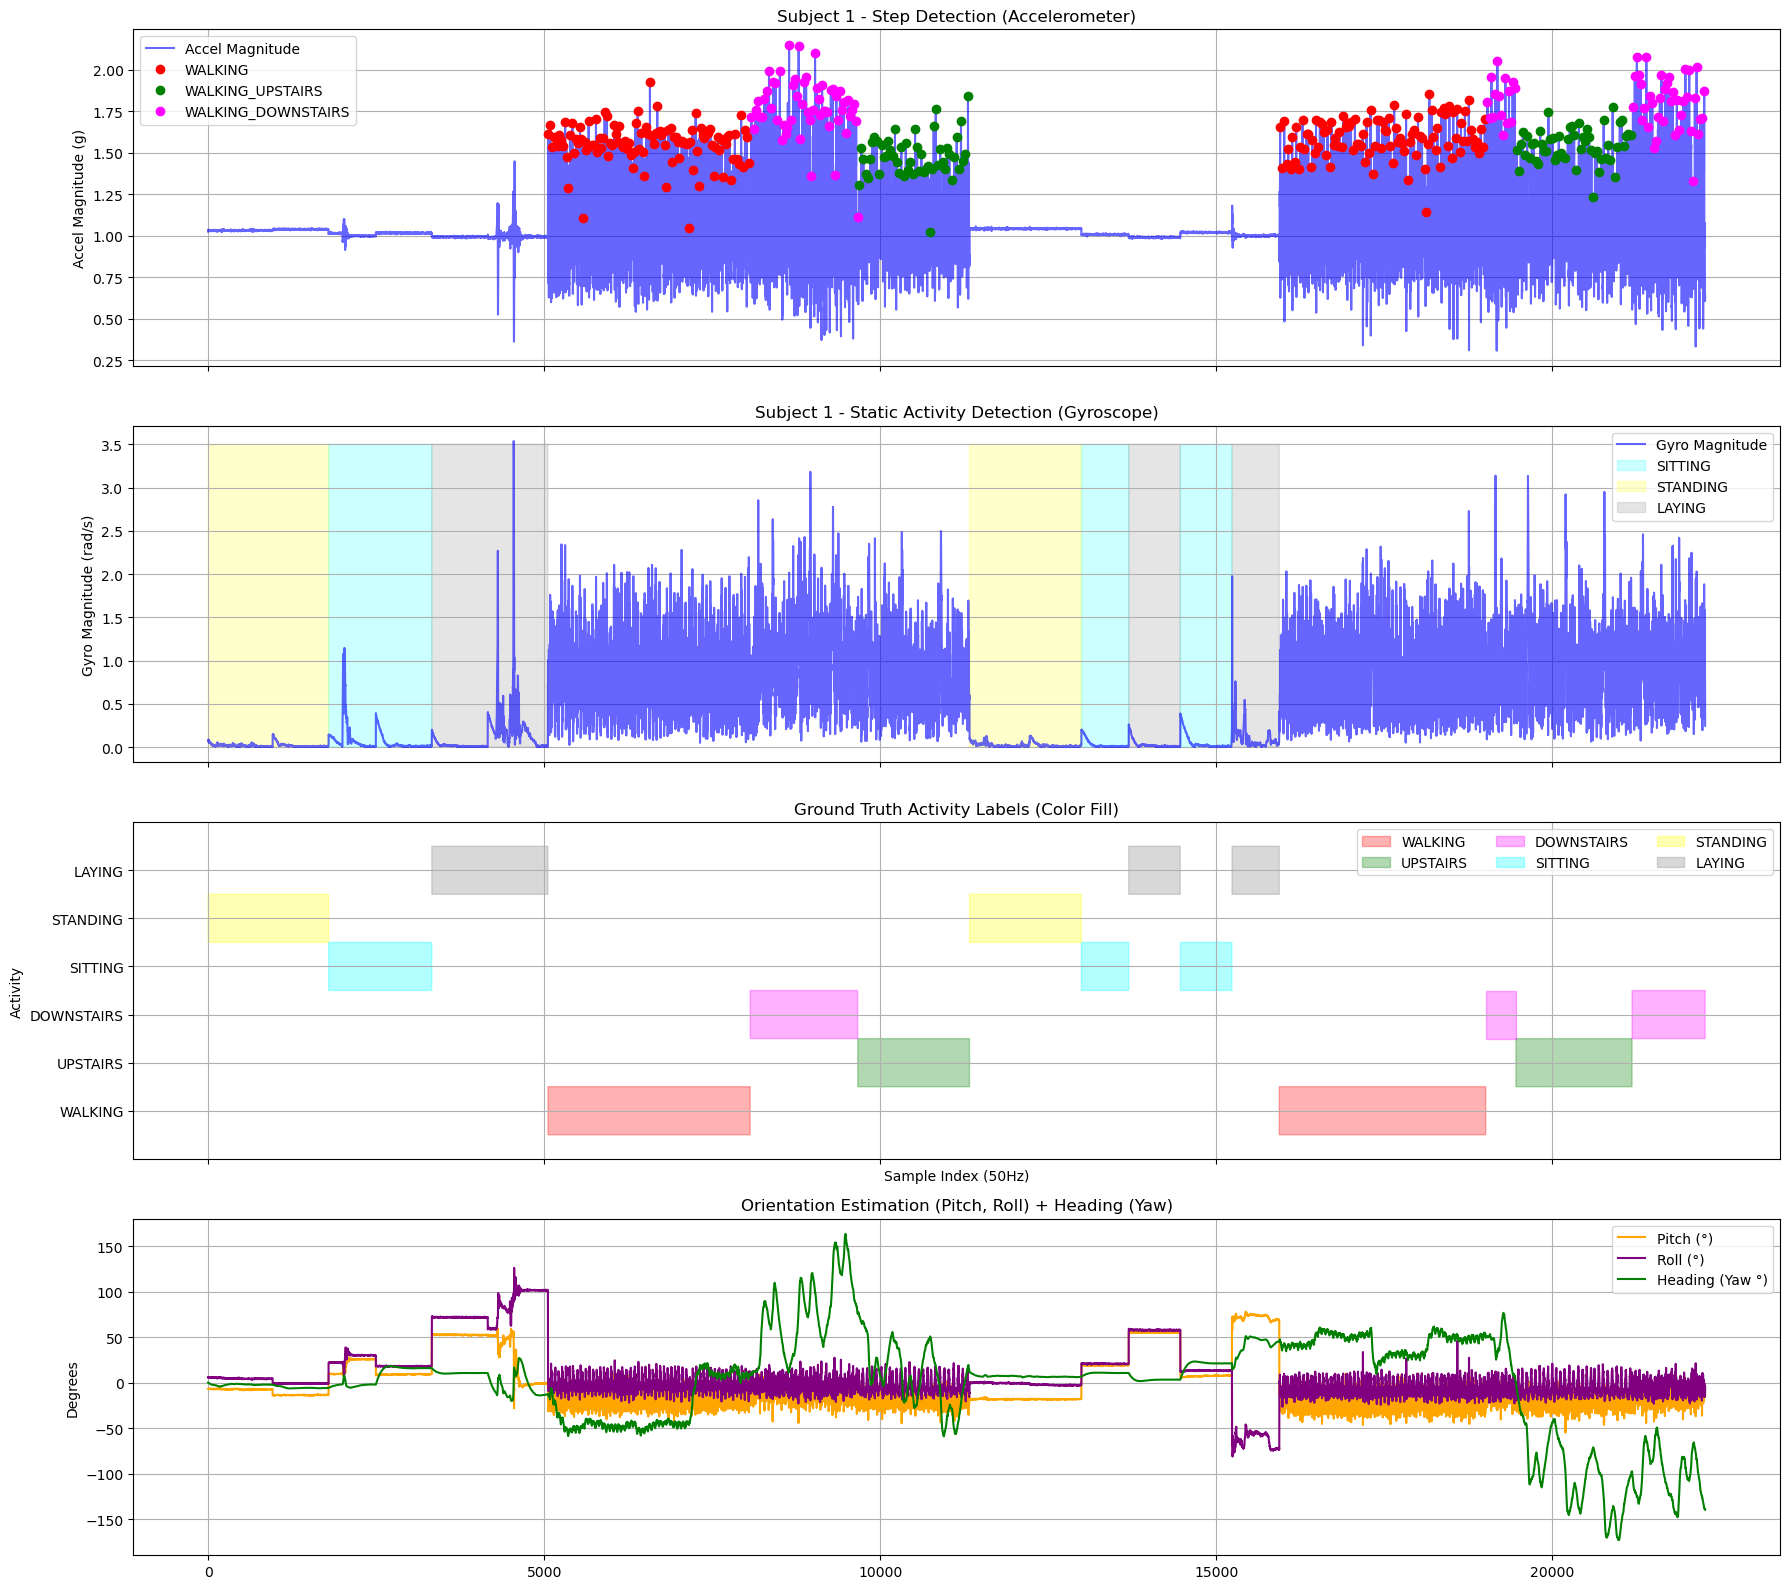

In [2]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# === Step 1: Filter Subject 1 ===
subject1_acc = acc_labeled[acc_labeled[:, 4] == 1]  # subject_id == 1
subject1_gyro = gyro_labeled[gyro_labeled[:, 4] == 1]
subject1_labels = subject1_acc[:, 3].astype(int)  # activity label column (index 3)

# === Step 2: Compute Acceleration Magnitude ===
acc_mag = np.sqrt(subject1_acc[:, 0]**2 + subject1_acc[:, 1]**2 + subject1_acc[:, 2]**2)

# === Step 2.1: Estimate Pitch and Roll from Accelerometer ===
# === Remap IMU axes to body frame ===
# IMU axes:       X = down, Y = backward, Z = right (phone in portrait mode)
# Body axes:      X = left-right, Y = forward, Z = up

# Remap:
acc_body_x = subject1_acc[:, 2]        # Use Z as left-right (body X)
acc_body_y = -subject1_acc[:, 1]       # Invert Y to make it forward (body Y)
acc_body_z = subject1_acc[:, 0]        # X (down) becomes up (body Z)

pitch = np.arctan2(-acc_body_y, np.sqrt(acc_body_x**2 + acc_body_z**2)) * (180 / np.pi)
roll  = np.arctan2(acc_body_x, acc_body_z) * (180 / np.pi)


# === Step 3: Detect Step Peaks ===
peaks, _ = find_peaks(acc_mag, height=0.2, distance=20)
print("\n✅ Total Detected Steps:", len(peaks))

# === Step 4: Label Peaks Based on Activity ===
step_labels = subject1_acc[peaks, 3].astype(int)

# === Step 5: Build Classification from Ground Truth ===
label_map = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

# Count step types
step_counts = {label_map[i]: np.sum(step_labels == i) for i in range(1, 4)}
print("\n✅ Step Count by Activity:")
for activity, count in step_counts.items():
    print(f"{activity}: {count} steps")

# === Step 6: Compute Gyro Magnitude ===
gyro_mag = np.sqrt(subject1_gyro[:, 0]**2 + subject1_gyro[:, 1]**2 + subject1_gyro[:, 2]**2)
activity_gyro = subject1_gyro[:, 3].astype(int)

# === Step 6.1: Estimate Heading (Yaw) by Integrating Gyro X ===
gyro_x = -subject1_gyro[:, 0]
dt = 1 / 50  # Sampling rate is 50Hz
heading = np.zeros_like(gyro_x)
for i in range(1, len(gyro_x)):
    heading[i] = heading[i - 1] + gyro_x[i] * dt  # rad/s * s = rad

# Optional: convert to degrees
heading_deg = np.rad2deg(heading)

# === Step 7: Plot All in One Figure ===

fig, axs = plt.subplots(4, 1, figsize=(18, 16), sharex=True)

# --- Top plot: Acceleration with steps ---
axs[0].plot(acc_mag, label="Accel Magnitude", color='blue', alpha=0.6)
for label, color, name in zip([1, 2, 3], ['red', 'green', 'magenta'], ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']):
    idx = peaks[step_labels == label]
    axs[0].plot(idx, acc_mag[idx], 'o', label=name, color=color)
axs[0].set_ylabel("Accel Magnitude (g)")
axs[0].set_title("Subject 1 - Step Detection (Accelerometer)")
axs[0].legend()
axs[0].grid(True)

# --- Middle plot: Gyroscope magnitude ---
x_gyro = np.arange(len(gyro_mag))
axs[1].plot(gyro_mag, label="Gyro Magnitude", color='blue', alpha=0.6)
axs[1].fill_between(x_gyro, 0, 3.5, where=(activity_gyro == 4), color='cyan', alpha=0.2, label='SITTING')
axs[1].fill_between(x_gyro, 0, 3.5, where=(activity_gyro == 5), color='yellow', alpha=0.2, label='STANDING')
axs[1].fill_between(x_gyro, 0, 3.5, where=(activity_gyro == 6), color='gray', alpha=0.2, label='LAYING')
axs[1].set_ylabel("Gyro Magnitude (rad/s)")
axs[1].set_title("Subject 1 - Static Activity Detection (Gyroscope)")
axs[1].legend()
axs[1].grid(True)

# --- Bottom plot: Ground truth activity label fill regions ---
x_acc = np.arange(len(subject1_labels))
axs[2].set_ylim(0, 7)
axs[2].set_yticks([1, 2, 3, 4, 5, 6])
axs[2].set_yticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
for label, color, name in zip([1, 2, 3, 4, 5, 6], ['red', 'green', 'magenta', 'cyan', 'yellow', 'gray'],
                              ['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']):
    axs[2].fill_between(x_acc, label-0.5, label+0.5, where=(subject1_labels == label), color=color, alpha=0.3, label=name)

axs[2].set_ylabel("Activity")
axs[2].set_xlabel("Sample Index (50Hz)")
axs[2].set_title("Ground Truth Activity Labels (Color Fill)")
axs[2].legend(ncol=3)
axs[2].grid(True)

# --- New Plot: Orientation (Pitch, Roll) and Heading ---
axs[3].plot(pitch, label="Pitch (°)", color='orange')
axs[3].plot(roll, label="Roll (°)", color='purple')
axs[3].plot(heading_deg, label="Heading (Yaw °)", color='green')
axs[3].set_ylabel("Degrees")
axs[3].set_title("Orientation Estimation (Pitch, Roll) + Heading (Yaw)")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


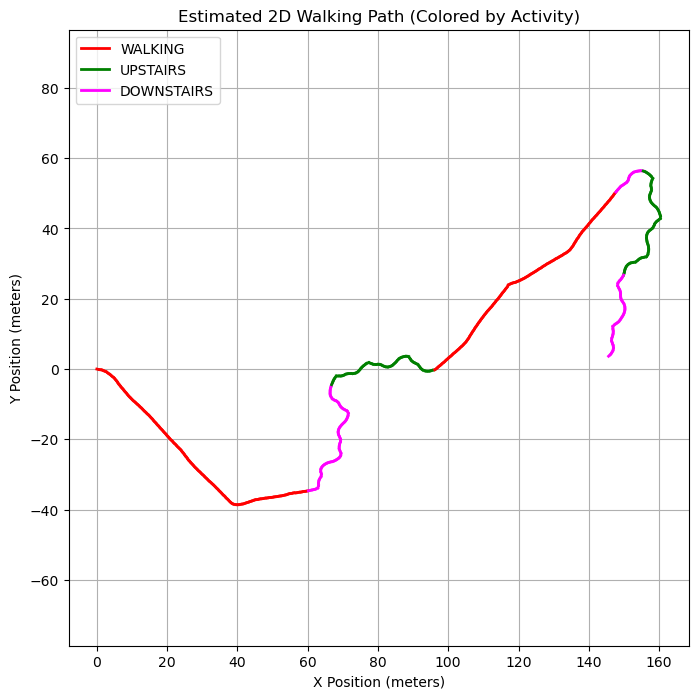

In [3]:
import math
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# === Step-to-2D-Path Conversion ===
step_length = 0.7  # meters per step (you can tune this)
x_path = [0]  # Start at origin
y_path = [0]

for i in range(1, len(peaks)):
    idx = peaks[i]
    angle_rad = heading[idx]

    # Filter: only move during walking, upstairs, downstairs
    label = step_labels[i - 1]
    if label in [1, 2, 3]:  # 1=WALKING, 2=UPSTAIRS, 3=DOWNSTAIRS
        x_new = x_path[-1] + step_length * np.cos(angle_rad)
        y_new = y_path[-1] + step_length * np.sin(angle_rad)
    else:
        # No forward movement
        x_new = x_path[-1]
        y_new = y_path[-1]

    x_path.append(x_new)
    y_path.append(y_new)

# Create color map for labels
label_map = {
    1: ("WALKING", 'red'),
    2: ("WALKING_UPSTAIRS", 'green'),
    3: ("WALKING_DOWNSTAIRS", 'magenta')
}

# Create 2D path with color-coded steps
plt.figure(figsize=(8, 8))
for i in range(1, len(x_path)):
    activity = step_labels[i - 1]  # Get label for this step
    label_name, color = label_map.get(activity, ("UNKNOWN", 'gray'))
    plt.plot([x_path[i - 1], x_path[i]], [y_path[i - 1], y_path[i]], color=color, linewidth=2)

# Build legend
legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in {
    "WALKING": 'red',
    "UPSTAIRS": 'green',
    "DOWNSTAIRS": 'magenta'
}.items()]
plt.legend(handles=legend_elements, loc='upper left')

plt.title("Estimated 2D Walking Path (Colored by Activity)")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.axis('equal')
plt.grid(True)
plt.show()


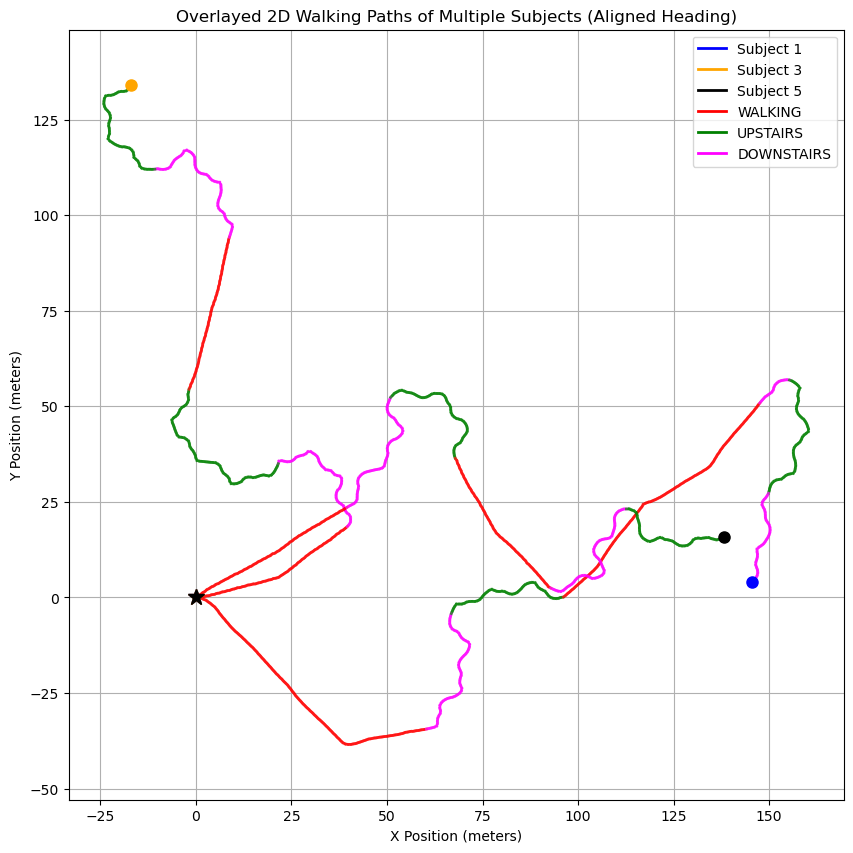

In [4]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

subject_ids_to_plot = [1, 3, 5]  # Subject IDs to plot
step_length = 0.7
dt = 1 / 50  # Sampling rate (Hz)

plt.figure(figsize=(10, 10))
legend_handles = []

label_map = {
    1: ("WALKING", 'red'),
    2: ("WALKING_UPSTAIRS", 'green'),
    3: ("WALKING_DOWNSTAIRS", 'magenta')
}

colors_for_subjects = ['blue', 'orange', 'black', 'brown', 'purple']
reference_heading = None  

for s_idx, subject_id in enumerate(subject_ids_to_plot):
    # === Filter Data ===
    acc_data = acc_labeled[acc_labeled[:, 4] == subject_id]
    gyro_data = gyro_labeled[gyro_labeled[:, 4] == subject_id]
    labels = acc_data[:, 3].astype(int)

    # === Remap Axes to Body Frame ===
    acc_x = acc_data[:, 0]         # IMU X (down) → Body Z (up)
    acc_y = acc_data[:, 1]         # IMU Y (backward) → Body Y (forward, needs flip)
    acc_z = acc_data[:, 2]         # IMU Z (right) → Body X (left-right)

    acc_body_x = acc_z             # left-right
    acc_body_y = -acc_y            # forward (negated)
    acc_body_z = acc_x             # up

    acc_xyz = np.stack((acc_body_x, acc_body_y, acc_body_z), axis=1)
    acc_mag = np.linalg.norm(acc_xyz, axis=1)

    # === Yaw from Gyro X (IMU X = body Z) and negate it ===
    gyro_yaw = -gyro_data[:, 0]  # Rotation around vertical (body Z)

    # === Integrate Heading ===
    heading = np.zeros_like(gyro_yaw)
    for i in range(1, len(gyro_yaw)):
        heading[i] = heading[i - 1] + gyro_yaw[i] * dt
        
    heading -= heading[find_peaks(acc_mag, height=0.2, distance=20)[0][0]]

    # === Step Detection ===
    peaks, _ = find_peaks(acc_mag, height=0.2, distance=20)
    step_labels = labels[peaks]

    # === Simulate 2D Path (Filtered by Activity)
    x_path, y_path = [0], [0]
    for i in range(1, len(peaks)):
        idx = peaks[i]
        angle_rad = heading[idx]
        label = step_labels[i - 1]

        if label in [1, 2, 3]:  # Only walk during valid movement
            x_new = x_path[-1] + step_length * np.cos(angle_rad)
            y_new = y_path[-1] + step_length * np.sin(angle_rad)
        else:
            x_new = x_path[-1]
            y_new = y_path[-1]

        x_path.append(x_new)
        y_path.append(y_new)

    # === Plot Colored Path ===
    for i in range(1, len(x_path)):
        activity = step_labels[i - 1]
        label_name, color = label_map.get(activity, ("UNKNOWN", 'gray'))
        plt.plot([x_path[i - 1], x_path[i]], [y_path[i - 1], y_path[i]],
                 color=color, linewidth=2, alpha=0.7, linestyle='-',
                 label=f"Subject {subject_id}" if i == 1 else "")

    # === Add Subject Legend Handle
    legend_handles.append(Line2D([0], [0], color=colors_for_subjects[s_idx],
                                 lw=2, label=f"Subject {subject_id}"))

    # === Plot Start and End Markers for Each Subject
    plt.plot(x_path[0], y_path[0], marker='*', color=colors_for_subjects[s_idx],
            markersize=12, label=f"Start S{subject_id}")
    plt.plot(x_path[-1], y_path[-1], marker='o', color=colors_for_subjects[s_idx],
            markersize=8, label=f"End S{subject_id}")


# === Legend for Activities + Subjects
activity_legend = [Line2D([0], [0], color=color, lw=2, label=label)
                   for label, color in {
                       "WALKING": 'red',
                       "UPSTAIRS": 'green',
                       "DOWNSTAIRS": 'magenta'
                   }.items()]
plt.legend(handles=legend_handles + activity_legend, loc='upper right')

plt.title("Overlayed 2D Walking Paths of Multiple Subjects (Aligned Heading)")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.axis('equal')
plt.grid(True)
plt.show()
